In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.sql import label
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, MetaData, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
from sqlalchemy import  func, Column, Integer, String, Float,Table,ForeignKey
from flask import jsonify

In [5]:
# Create Database Connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [6]:
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns=inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
# reflect an existing database into a new model
Base = automap_base()

Base.metadata.create_all(engine)
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(func.count(Measurement.date)).all()

[(19550)]

In [13]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [14]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [15]:
# Calculate the date 1 year ago from today
one_year_ago = dt.date.today() - dt.timedelta(days=365)
print(one_year_ago)

2017-10-16


In [16]:
# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2011-08-23').filter(Measurement.date <= '2012-08-23').order_by(Measurement.date).all()

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcd_df = pd.DataFrame(last_12_months, columns=['date', 'prcp'])
prcd_df.head()

,date,prcp
0,2011-08-23,0.00
1,2011-08-23,0.21
2,2011-08-23,0.00
3,2011-08-23,0.22
4,2011-08-23,0.17


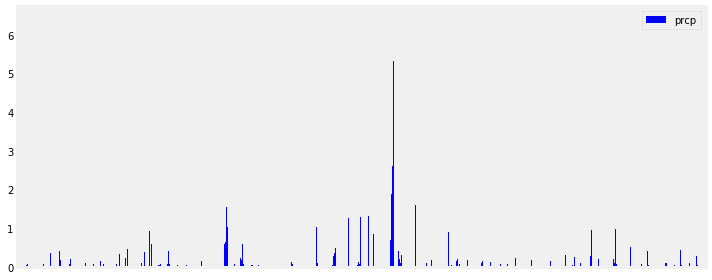

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcd_ax = prcd_df.plot('date','prcp', kind='bar', color="blue", figsize=(10,4), alpha=0.9999)
prcd_ax.get_xaxis().set_visible(False)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.grid(which='major')
plt.savefig("Output/precipitation.png")
plt.tight_layout()
plt.show()

# Rotate the xticks for the dates

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcd_df.describe()

,prcp
count,2516.000000
mean,0.133712
std,0.458774
min,0.000000
25%,0.000000
50%,0.010000
75%,0.080000
max,6.420000


In [20]:
# How many stations are available in this dataset?
avail_stations = session.query(Station.station).order_by(Station.station).count()
print(f"Total number of stations:  {avail_stations}")

Total number of stations:  9


In [21]:
# What are the most active stations?
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.station)]
active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# Lowest Temperature recorded
lowest_temp = session.query(func.min(Measurement.tobs)).all()
lowest_temp

[(53.0)]

In [23]:
# Highest Temperature recorded
highest_temp = session.query(func.max(Measurement.tobs)).all()
highest_temp

[(87.0)]

In [24]:
# Average Temperature
average_temperature = session.query(func.avg(Measurement.tobs)).all()
average_temperature

[(73.09795396419437)]

In [25]:
# Choose the station with the highest number of temperature observations
sel = [Measurement.station, func.count(Measurement.station)]
most_active_stations_tobs = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
most_active_stations_tobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Query the last 12 months of temperature observation data for this station 
last_12_months = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').order_by(Measurement.date).all()
last_12_months

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [27]:
# Save the query results as a Pandas DataFrame and set the index to the date column
tobs_df = pd.DataFrame(last_12_months, columns=['date', 'tobs'])

# Sort the dataframe by date 
# prcd_df.set_index('date', inplace=True)
tobs_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


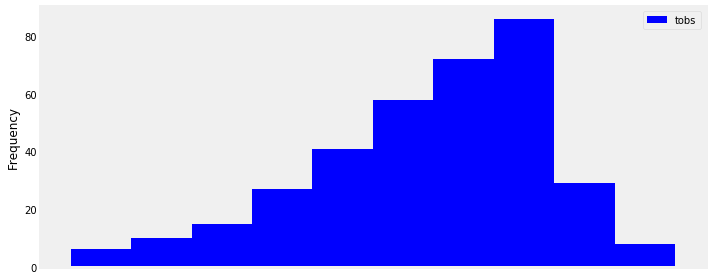

In [28]:
# plot the results as a histogram
prcd_ax = tobs_df.plot('date','tobs', kind='hist', color="blue",figsize=(10,4), alpha=0.9999)
prcd_ax.get_xaxis().set_visible(False)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.grid(which='major')
plt.savefig("Output/tobs_histogram.png")
plt.tight_layout()
plt.show()

In [29]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_mam = calc_temps('2011-08-23', '2012-08-23')
temp_info = temp_mam[0]
temp_info

(56.0, 72.34107076001497, 86.0)

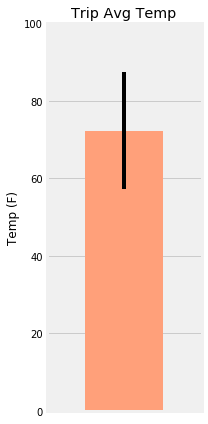

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_min = temp_info[0]
temp_avg = temp_info[1]
temp_max = temp_info[2]
x=0
y_error_bar = round(temp_max - temp_min,0)
fig,ax = plt.subplots(figsize=(3,6))

plt.bar(x, temp_avg, width=.25, yerr=.5*(y_error_bar), alpha=.9999, color='lightsalmon')

plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.ylim(0, 100)
plt.xlim(-.25,.25)
ax.set_xticklabels([])
plt.grid(False, axis="x")
plt.savefig("Output/trip_avg_temp.png")

# .plot()
plt.tight_layout()
plt.show()

In [32]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [33]:
columns=inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [34]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_per_station = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                filter(Measurement.date.between('2010-08-23','2011-08-23')).\
                group_by(Measurement.station).\
                join(Station, Measurement.station==Station.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()

print(rain_per_station)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 146.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 91.88000000000007), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 71.63000000000008), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 45.54), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 45.27000000000004), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 37.82000000000002), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 30.41000000000004), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 22.720000000000017), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 12.319999999999999)]


In [35]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rainfall_df = pd.DataFrame(rain_per_station, columns=['station', 'name','latitude','longitude', 'elevation', 'rainfall'])

# Sort the dataframe by date 
# prcd_df.set_index('date', inplace=True)
rainfall_df.head()

,station,name,latitude,longitude,elevation,rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,146.40
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,91.88
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,71.63
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,45.54
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,45.27


## Optional Challenge Assignment

In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [39]:
# Plot the daily normals as an area plot with `stacked=False`
